# MNIST dataset: Baselines


In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from keras import backend as K
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imsave
import numpy as np
import time
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.cross_validation import train_test_split

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *
from sklearn import decomposition
import warnings

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4835942002986268235
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3804889088
locality {
  bus_id: 1
}
incarnation: 18266678275628777703
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [2]:
# custom libraries
# Meta-Parameters
#base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
#base_dir = '/home/cyrilwendl'  # for GCE
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Zurich/helpers') # Path to density Tree package
from helpers.data_augment import *

# Data Import 
Import the data, delete all data in the training set of class 7


In [3]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train, return_counts=True))

label_to_remove = 7

# remove all trainig samples containing a label label_to_remove
x_train = x_train[y_train!=label_to_remove]
y_train = y_train[y_train!=label_to_remove]
    
x_test = x_test_all[y_test_all!=label_to_remove]
y_test = y_test_all[y_test_all!=label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove+1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))


In [4]:
batch_size = 128
num_classes = 9
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples


In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist-weights.h5')
else :
    model = load_model('mnist-weights.h5')

#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Make some predictions for the unseen class

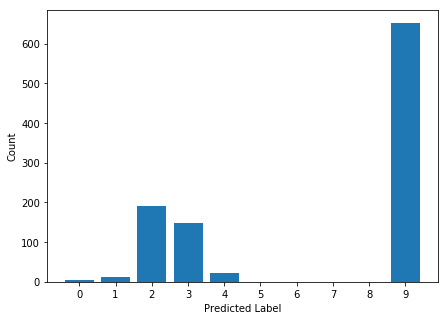

In [6]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all==label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = np.argmax(y_pred, axis = 1);

for i in range(label_to_remove, 9):
    y_pred_label[y_pred_label == i] = (i+1)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label,return_counts=True)

# visualization
fig = plt.figure(figsize=(7,5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0,10))
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.savefig("../Figures/pred-count.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [7]:
# Avarage certitude for unseen class: 1-max_margin
c = []
for i in range(len(y_pred_label)):
    y_probas = np.sort(y_pred[i])  # probabilities for one image
    c.append(y_probas[-1]-y_probas[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100

print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 67.54 %
Std accuracy: 32.05 %
31.32% of all predictions made with an accuracy higher than 0.95%


In [8]:
# Avarage certitude for seen class: 1-max_margin
y_pred_seen = model.predict(x_test)
y_pred_label_seen = np.argmax(y_pred_seen, axis = 1);

for i in np.flip(range(label_to_remove,9),axis=0):
    y_pred_label_seen[y_pred_label_seen == i] = (i+1)

c = []
for i in range(len(y_pred_label_seen)):
    y_probas_seen = np.sort(y_pred_seen[i])  # probabilities for one image
    c.append(y_probas_seen[-1]-y_probas_seen[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f %% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 97.99 %
Std accuracy: 9.79 %
94.32 % of all predictions made with an accuracy higher than 0.95%


In [9]:
y_pred = model.predict(x_test_all)
y_pred_label = np.argmax(y_pred, axis = 1);

for i in np.flip(range(label_to_remove,9),axis=0):
    y_pred_label[y_pred_label == i] = (i+1)

In [10]:
print(metrics.classification_report(y_pred_label,y_test_all))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       996
          1       1.00      0.98      0.99      1152
          2       0.99      0.84      0.91      1227
          3       1.00      0.86      0.92      1164
          4       0.99      0.97      0.98      1001
          5       0.99      0.99      0.99       890
          6       0.98      0.99      0.99       950
          7       0.00      0.00      0.00         0
          8       0.98      0.98      0.98       973
          9       0.98      0.60      0.75      1647

avg / total       0.99      0.89      0.93     10000



/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Baseline Method
## Confidence from Invariance to Image Transformations
https://arxiv.org/pdf/1804.00657.pdf

In [11]:
import keras.backend as K
from tqdm import tqdm

In [12]:
# function to implement prediction with dropout
f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

def predict_with_dropout(x, n_iter=10):    
    pred = np.concatenate([f([x, 1]) for _ in range(n_iter)] )
    return pred

# get predictions

# image 17
def predict_with_dropouts_aux(x, batch_size=300, n_iter=10):
    """make all predictions per batch"""
    n_steps = int(np.ceil(len(x)/batch_size))
    preds = []
    for i in tqdm(range(n_steps)):
        idx_start = i*batch_size
        idx_end = (i+1)*batch_size
        pred = predict_with_dropout(x[idx_start:idx_end], n_iter=n_iter)
        pred = np.transpose(pred, (1,0,2))
        preds.append(pred)
    
    preds = np.concatenate(preds)
    preds = np.transpose(preds, (1,0,2))
    return preds
    

y_pred = predict_with_dropouts_aux(x_test_all, batch_size=500, n_iter = 20)

100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


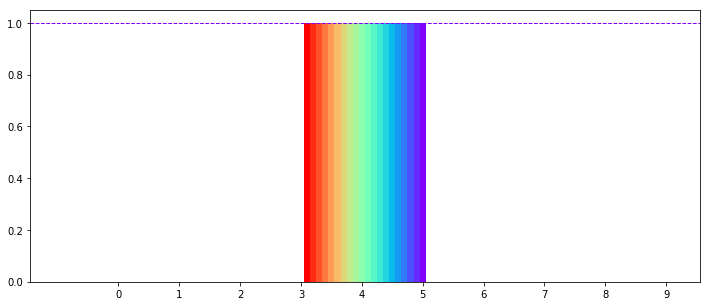

True label: 4


In [13]:
from matplotlib.pyplot import cm

def show_softmax(idx, y_pred, y_true=None):
    softmax_im = [y_pred[i][idx] for i in range(len(y_pred))]
    plt.figure(figsize=(12, 5))
    ax = plt.subplot(111)
    x=np.arange(9)
    bars=[]
    color = cm.rainbow(np.linspace(0, 1, len(y_pred)))
    for i in range(len(y_pred)):
        bars.append(ax.bar(len(y_pred)/20+x-1/10*i, softmax_im[i] ,width=0.1, align='center', color=color[i]))
    ax.axhline(np.max(y_pred[0][idx]),c=color[0], ls='--', lw=1)
    ax.set_xticks(np.arange(10))
    plt.show()
    if y_true is not None:
        print("True label: %i" % y_true[idx])
    
idx = 4
show_softmax(idx, y_pred, y_test_all)

In [14]:
y_test_all

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [15]:
filt = (np.equal(y_pred_label,y_test_all) == False) & (y_test_all!=label_to_remove)
x_wrong = x_test_all[filt]
y_wrong = y_test_all[filt]
idx_wrong = np.where(filt)[0]

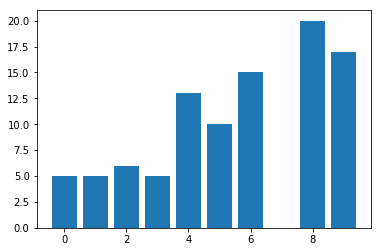

In [16]:
plt.bar(*np.unique(y_wrong,return_counts=True))
plt.show()

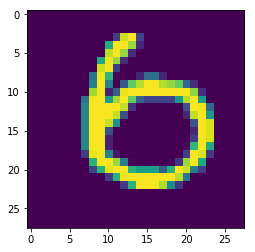

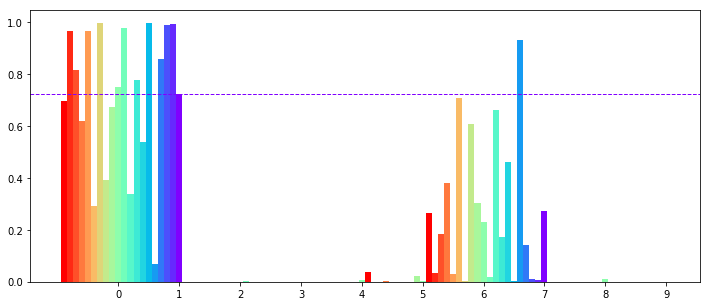

True label: 6


In [17]:
# plot a wrongly predicted image and its softmax output
idx = idx_wrong[1]
plt.imshow(x_test_all[idx][...,0])
plt.show()
show_softmax(idx, y_pred, y_test_all)

In [18]:
from copy import deepcopy

In [19]:
# loop all data points
def reorder_truncate_concatenate(y_pred, n_components):
    """ 
    reorder, truncate, concatenate prediction vectors
    y_pred = [n_transforms, n_points, n_classes]
    """
    # reorder
    y_pred_o = deepcopy(y_pred)
    for i in range(np.shape(y_pred)[1]): # loop n_points
        order = np.argsort(y_pred_o[0][i])
        # reorder class scores by descending original score
        for j in range(len(y_pred)):  # loop n_transforms
            sort_order = np.flip(np.argsort(y_pred_o[0][i]), axis=0)
            y_pred_o[j][i] = y_pred_o[j][i][sort_order]
    
    # truncate
    y_pred_t = []
    
    y_pred_t = np.asarray([y_pred[:,:n_components] for y_pred in y_pred])
       
    # concatenate
    y_pred_c = np.concatenate(y_pred_t, axis=-1)
    return y_pred_t, y_pred_c
y_pred_t, y_pred_c = reorder_truncate_concatenate(y_pred, 9)

In [20]:
# get training data and labels
x = y_pred_c
y = (np.equal(y_pred_label,y_test_all) == True)*1.

In [21]:
# split training data in train and test part
indices = np.arange(len(x))
x_train, x_test, y_train, y_test, ind_train, ind_test = train_test_split(x, y, indices, test_size=0.5, random_state=42)

In [22]:
# convert class vectors to binary class matrices
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [23]:
from keras.optimizers import Adam
# KERAS, for GPU use
# Train MLP
n_cl = 2
model_mlp = Sequential()
model_mlp.add(Dense(70, activation='relu', input_shape=(x_train.shape[1:])))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(70, activation='relu'))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(n_cl, activation='softmax'))

model_mlp.summary()

model_mlp.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

batch_size = 200
epochs = 40
history = model_mlp.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))
score = model_mlp.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 70)                12670     
_________________________________________________________________
dropout_3 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 70)                4970      
_________________________________________________________________
dropout_4 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 142       
Total params: 17,782
Trainable params: 17,782
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.12282104893028736
Test accuracy: 0.9586


In [24]:
pred = np.argmax(model_mlp.predict(x),-1)
y_pred_label_y = y_test_all*np.equal(y,pred)*1

In [25]:
# show scores for images that were correctly or incorrectly predicted as correct / incorrect
print(metrics.classification_report(y_test_all, y_pred_label_y))

             precision    recall  f1-score   support

          0       0.75      1.00      0.86       980
          1       1.00      1.00      1.00      1135
          2       1.00      0.98      0.99      1032
          3       1.00      0.99      1.00      1010
          4       1.00      0.99      1.00       982
          5       1.00      0.99      1.00       892
          6       1.00      0.99      0.99       958
          7       1.00      0.80      0.89      1028
          8       1.00      0.99      0.99       974
          9       1.00      0.95      0.97      1009

avg / total       0.98      0.97      0.97     10000



In [26]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [27]:
s = np.shape(y_pred_t)
t = np.reshape(y_pred_t, (s[1],s[0],s[2]))

In [28]:
KL_pts = []
for pt_idx in range(len(t)): # loop points
    KL_pt = []
    for t_idx in range(np.shape(t)[1]): # loop transformations
        KL_pt.append(KL(t[pt_idx][0],t[pt_idx][t_idx]))
    KL_pts.append(KL_pt)

KL_pts = np.asarray(KL_pts)

/opt/conda/envs/python36/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/envs/python36/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


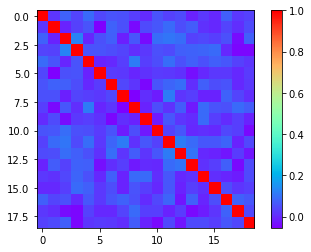

In [29]:
c = np.corrcoef(KL_pts.T)
c = c[1:,1:]
plt.imshow(c, cmap='rainbow')
plt.colorbar()

Text(0.5,1,'Mean probability to have a correct prediction in class')

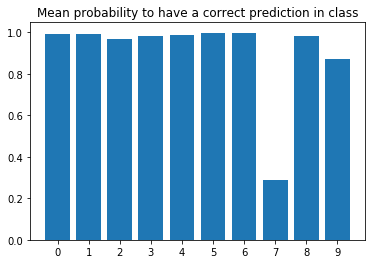

In [30]:
# get mean proba in all 
proba_correct = model_mlp.predict(x_test)[:,1]  # probability to have a correct prediction

av_p = []

for i in range(10):
    av_p_i = np.mean(proba_correct[y_test_all[ind_test]==i])
    av_p.append(av_p_i)


plt.bar(range(10), av_p)
plt.xticks(range(10))
plt.title("Mean probability to have a correct prediction in class")



Mean accuracy: 94.86 %
Std accuracy: 16.65 %
87.84% of all predictions made with an accuracy higher than 0.95%


Text(0.5,1,'Mean certainty by Network')

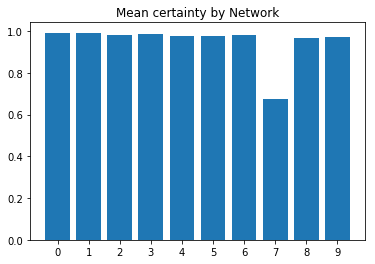

In [31]:
# for comparison: mean margin by network
# make prodictions for class unseen during training
y_pred = model.predict(x_test_all)
y_pred_label = np.argmax(y_pred, axis = 1);

for i in range(label_to_remove, 9):
    y_pred_label[y_pred_label == i] = (i+1)

c = []
for i in range(len(y_pred_label)):
    y_probas = np.sort(y_pred[i])  # probabilities for one image
    c.append(y_probas[-1]-y_probas[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

c = np.asarray(c)
pred_acc_high = .95 # 95 % is considered a very high confidence


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100

print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

# get mean proba in all 
av_p = []

for i in range(10):
    av_p_i = np.mean(c[y_test_all==i])
    av_p.append(av_p_i)


plt.bar(range(10), av_p)
plt.xticks(range(10))
plt.title("Mean certainty by Network")